# Inspecting Call Stacks

This appendix introduces a class for inspecting the call stack at runtime.

**Prerequisites**

* This is an internal helper class.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.StackInspector import <identifier>
```

and then make use of the following features.


`StackInspector` is typically used as superclass, providing its functionality to subclasses:

```python
>>> class StackInspectorDemo(StackInspector):
>>>     def callee(self) -> Tuple[Location, Dict[str, Any]]:
>>>         return self.caller_location(), self.caller_locals()
>>> 
>>>     def caller(self) -> Tuple[Location, Dict[str, Any]]:
>>>         return self.callee()
```
The function `test()` should return a pair consisting of the location of the caller (`test()`) and a dictionary of local variables in this caller.

```python
>>> def test() -> Tuple[Location, Dict[str, Any]]:
>>>     demo = StackInspectorDemo()
>>>     return demo.caller()

>>> test()

((<function __main__.test() -> Tuple[Tuple[Callable, int], Dict[str, Any]]>,
  3),
 {'demo': <__main__.StackInspectorDemo at 0x7fcf7249a048>})
```
Here are all methods defined in this appendix:


![](PICS/StackInspector-synopsis-1.svg)



In this book, for many purposes, we need to lookup a function's location, source code, or simply definition. The class `StackInspector` provides a number of convenience methods for this purpose.

When we access or execute functions, we do so in the  caller's environment, not ours. The `caller_globals()` method acts as replacement for `globals()`.

The method `caller_frame()` walks up the current call stack and returns the topmost frame invoking a method or function from the current class. 

In [1]:
import bookutils

In [2]:
import inspect
import warnings

In [3]:
from types import FunctionType, FrameType, TracebackType

In [4]:
from typing import cast, Dict, Any, Tuple, Callable, Optional, Type

In [5]:
class StackInspector:
    """Provide functions to inspect the stack"""

    def caller_frame(self) -> FrameType:
        """Return the frame of the caller."""

        # Walk up the call tree until we leave the current class
        frame = cast(FrameType, inspect.currentframe())

        while self.our_frame(frame):
            frame = cast(FrameType, frame.f_back)

        return frame

    def our_frame(self, frame: FrameType) -> bool:
        """Return true if `frame` is in the current (inspecting) class."""
        return isinstance(frame.f_locals.get('self'), self.__class__)

    def caller_globals(self) -> Dict[str, Any]:
        """Return the globals() environment of the caller."""
        return self.caller_frame().f_globals

    def caller_locals(self) -> Dict[str, Any]:
        """Return the locals() environment of the caller."""
        return self.caller_frame().f_locals

`caller_location()` returns the caller's function and its location. It does a fair bit of magic to retrieve nested functions, by looking through global and local variables until a match is found. This may be simplified in the future.

In [6]:
Location = Tuple[Callable, int]

In [7]:
class StackInspector(StackInspector):
    def caller_location(self) -> Location:
        """Return the location (func, lineno) of the caller."""
        return self.caller_function(), self.caller_frame().f_lineno

    def search_frame(self, name: str, frame: Optional[FrameType] = None) -> \
        Tuple[Optional[FrameType], Optional[Callable]]:
        """
        Return a pair (`frame`, `item`) 
        in which the function `name` is defined as `item`.
        """
        if frame is None:
            frame = self.caller_frame()

        while frame:
            item = None
            if name in frame.f_globals:
                item = frame.f_globals[name]
            if name in frame.f_locals:
                item = frame.f_locals[name]
            if item and callable(item):
                return frame, item

            frame = cast(FrameType, frame.f_back)

        return None, None

    def search_func(self, name: str, frame: Optional[FrameType] = None) -> \
        Optional[Callable]:
        """Search in callers for a definition of the function `name`"""
        frame, func = self.search_frame(name, frame)
        return func

    # Avoid generating functions more than once
    _generated_function_cache: Dict[Tuple[str, int], Callable] = {}

    def create_function(self, frame: FrameType) -> Callable:
        """Create function for given frame"""
        name = frame.f_code.co_name
        cache_key = (name, frame.f_lineno)
        if cache_key in self._generated_function_cache:
            return self._generated_function_cache[cache_key]

        try:
            # Create new function from given code
            generated_function = cast(Callable,
                                      FunctionType(frame.f_code,
                                                   globals=frame.f_globals,
                                                   name=name))
        except TypeError:
            # Unsuitable code for creating a function
            # Last resort: Return some function
            generated_function = self.unknown

        except Exception as exc:
            # Any other exception
            warnings.warn(f"Couldn't create function for {name} "
                          f" ({type(exc).__name__}: {exc})")
            generated_function = self.unknown

        self._generated_function_cache[cache_key] = generated_function
        return generated_function

    def caller_function(self) -> Callable:
        """Return the calling function"""
        frame = self.caller_frame()
        name = frame.f_code.co_name
        func = self.search_func(name)
        if func:
            return func

        if not name.startswith('<'):
            warnings.warn(f"Couldn't find {name} in caller")

        return self.create_function(frame)

    def unknown(self) -> None:  # Placeholder for unknown functions
        pass

The method `is_internal_error()` allows us to differentiate whether some exception was raised by `StackInspector` (or a subclass) – or whether it was raised by the inspected code.

In [8]:
import traceback

In [9]:
class StackInspector(StackInspector):
    def is_internal_error(self, exc_tp: Type, 
                          exc_value: BaseException, 
                          exc_traceback: TracebackType) -> bool:
        """Return True if exception was raised from `StackInspector` or a subclass."""
        if not exc_tp:
            return False

        for frame, lineno in traceback.walk_tb(exc_traceback):
            if self.our_frame(frame):
                return True

        return False

## Synopsis

`StackInspector` is typically used as superclass, providing its functionality to subclasses:

In [10]:
class StackInspectorDemo(StackInspector):
    def callee(self) -> Tuple[Location, Dict[str, Any]]:
        return self.caller_location(), self.caller_locals()

    def caller(self) -> Tuple[Location, Dict[str, Any]]:
        return self.callee()

The function `test()` should return a pair consisting of the location of the caller (`test()`) and a dictionary of local variables in this caller.

In [11]:
def test() -> Tuple[Location, Dict[str, Any]]:
    demo = StackInspectorDemo()
    return demo.caller()

In [12]:
test()

((<function __main__.test() -> Tuple[Tuple[Callable, int], Dict[str, Any]]>,
  3),
 {'demo': <__main__.StackInspectorDemo at 0x7fcf7249a048>})

Here are all methods defined in this appendix:

In [13]:
# ignore
from ClassDiagram import display_class_hierarchy, class_tree

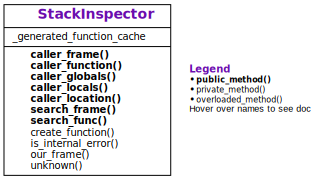

In [14]:
# ignore
display_class_hierarchy([StackInspector],
                        abstract_classes=[
                            StackInspector,
                        ],
                        public_methods=[
                            StackInspector.caller_frame,
                            StackInspector.caller_function,
                            StackInspector.caller_globals,
                            StackInspector.caller_locals,
                            StackInspector.caller_location,
                            StackInspector.search_frame,
                            StackInspector.search_func,
                        ],
                        project='debuggingbook')

## Lessons Learned

* In Python, inspecting objects at runtime is easy.